In [156]:
import numpy as np
import matplotlib.pyplot as plt
#%config InlineBackend.figure_format = 'retina'  # For sharper figures, but it takes more time
import scipy as sp
from copy import deepcopy 

from lisatools.utils.constants import *
from lisatools.sensitivity  import SensitivityMatrix, AET1SensitivityMatrix, AE1SensitivityMatrix
from lisatools.analysiscontainer import AnalysisContainer
from lisatools.datacontainer import DataResidualArray

from bbhx.waveforms.phenomhm import PhenomHMAmpPhase
from bbhx.waveformbuild import BBHWaveformFD
from bbhx.utils.interpolate import CubicSplineInterpolant

import noise_generation as noise_generation
from tools.LISASimulator import LISASimulator
from tools.likelihood import get_dh, get_hh
import tools.likelihood as likelihood

from tools.time_freq_likelihood import TimeFreqLikelihood

from chainconsumer import Chain, ChainConsumer, make_sample, Truth
import pandas as pd

In [157]:
Tobs = YRSID_SI/12
dt = 5.
include_T_channel = False # Set to True if you want to include the T channel in the simulation, otherwise only A and E channels will be included.

wave_gen = BBHWaveformFD(amp_phase_kwargs=dict(run_phenomd=False))
sim = LISASimulator(Tobs=Tobs, dt=dt, wave_gen=wave_gen, include_T_channel=include_T_channel)

m1 = 3e5
m2 = 1.5e5
a1 = 0.2
a2 = 0.4
dist = 8e3 * PC_SI * 1e6 
phi_ref = np.pi/2
f_ref = 0.0
inc = np.pi/3
lam = np.pi/1.
beta = np.pi/2-0.01
psi = np.pi/4.
t_ref = 0.95 * Tobs
#t_ref = round(0.9 * Tobs / dt) * dt  # round to the nearest multiple of dt, to force t_ref to be a part of t_array

parameters = np.array([m1, m2, a1, a2, dist, phi_ref, f_ref, inc, lam, beta, psi, t_ref])

modes = [(2,2), (2,1), (3,3), (3,2), (4,4), (4,3)]
waveform_kwargs = dict(direct=False, fill=True, squeeze=False, length=1024)

data_t, data_f, f_array, t_array, sens_mat = sim(seed = 42, parameters=parameters, modes=modes, waveform_kwargs=waveform_kwargs)

In [158]:
nwalkers = 50
ntemps = 4
ndims = 12
nleaves_max = 1
nsteps = 300

In [159]:
nperseg = 5000
time_before_merger = 60*60*12
cutoff_time = t_ref - time_before_merger
max_time = t_ref + 60*60*12

[1173.97949483]
1173.8586341775929


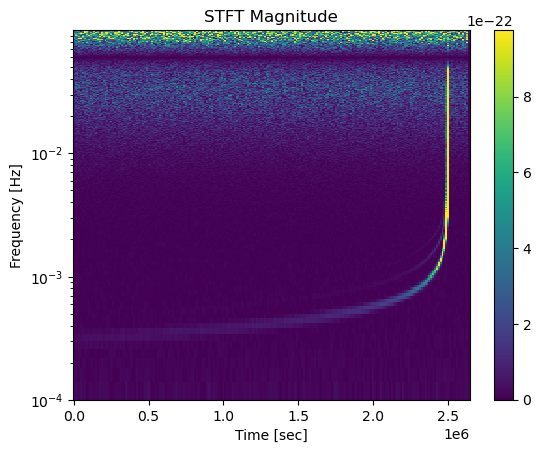

In [160]:
sim.plot_time_frequency(nperseg=nperseg)
print(sim.SNR_optimal())
print(likelihood.template_snr(data_f, sim.signal_f, AE1SensitivityMatrix(f_array), df=sim.df))

In [161]:
# Check is the likelihood is zero by computing the likelihood of a template with the true parameters with the noise-free signal.
analysis_no_noise = TimeFreqLikelihood(data_t=sim.signal_t[0], wave_gen=wave_gen)
analysis_no_noise.get_stft_of_data()
analysis_no_noise.calculate_time_frequency_likelihood(
    m1,
    m2, 
    a1,
    a2,
    dist, 
    phi_ref,
    f_ref, 
    inc,
    lam,
    beta,
    psi,
    t_ref,
    waveform_kwargs=dict(
        length=1024, 
        direct=False,
        fill=True,
        squeeze=False,
        freqs=f_array,
        modes=modes
    )
)

np.float64(0.0)

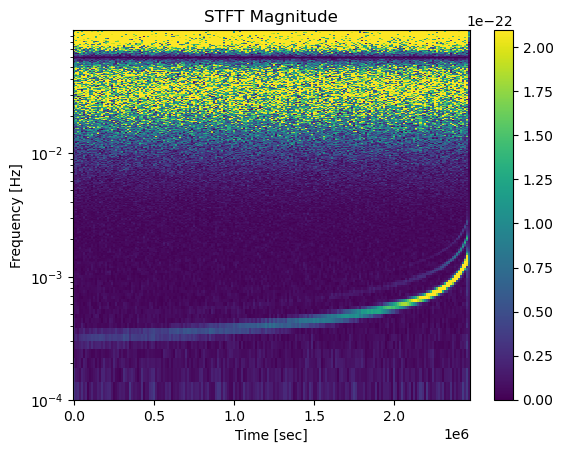

In [162]:
analysis = TimeFreqLikelihood(data_t=data_t, wave_gen=wave_gen, nperseg=nperseg)
analysis.pre_merger(time_before_merger=time_before_merger, t_ref=t_ref, t_array=t_array, )
analysis.get_stft_of_data()
analysis.plot_spectrogram()

In [163]:
print("Best likelihood (true parameters)= ", analysis.calculate_time_frequency_likelihood(
    m1,
    m2, 
    a1,
    a2,
    dist, 
    phi_ref,
    f_ref, 
    inc,
    lam,
    beta,
    psi,
    t_ref,
    waveform_kwargs=dict(
        length=1024, 
        combine=False,  # TODO: check this
        direct=False,
        fill=True,
        squeeze=True,
        freqs=f_array,
        modes=modes
    )
))
print("Likelihood of a random template = ", analysis.calculate_time_frequency_likelihood(
    m1 *20* (1 + 1e-7 * np.random.randn(1))[0],
    m2 * (1 + 1e-7 * np.random.randn(1))[0], 
    a1,
    a2,
    dist * 10, 
    phi_ref * (1 + 1e-7 * np.random.randn(1))[0],
    f_ref, 
    inc,
    lam*2,
    beta,
    psi,
    t_ref * (1 + 1e-7 * np.random.randn(1))[0],
    waveform_kwargs=dict(
        length=1024, 
        combine=False,  # TODO: check this
        direct=False,
        fill=True,
        squeeze=True,
        freqs=f_array,
        modes=modes
    )
))#/analysis.dt

Best likelihood (true parameters)=  -38.170822875453176
Likelihood of a random template =  -86.3961180827431


In [164]:
# imports
from eryn.ensemble import EnsembleSampler
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.state import State

In [165]:
def likelihood(x, freqs, TimeFreqLikelihood_object):
    all_parameters = np.zeros(12)
    mT = x[0]
    q = x[1]
    all_parameters[0] = mT / (1 + q)
    all_parameters[1] = mT * q / (1 + q)
    all_parameters[2] = x[2]
    all_parameters[3] = x[3]
    all_parameters[4] = x[4] * PC_SI * 1e6
    all_parameters[5] = x[5]
    all_parameters[6] = f_ref
    all_parameters[7] = x[7]
    all_parameters[8] = x[8]
    all_parameters[9] = np.arcsin(x[9])
    all_parameters[10] = x[10]
    all_parameters[11] = x[11]

    ll = TimeFreqLikelihood_object.calculate_time_frequency_likelihood(
        *all_parameters,
        waveform_kwargs=dict(
        length=1024, 
        direct=False,
        fill=True,
        squeeze=False,
        freqs=freqs,
        modes=modes
        )
    )
    return ll

In [166]:
priors = {"mbh": ProbDistContainer({
    0 : uniform_dist(1e5, 1e6),                  # mT = m1 + m2
    1 : uniform_dist(0.05, 0.999999),            # q = m2/m1
    2 : uniform_dist(-0.99999999, +0.99999999),  # a1
    3 : uniform_dist(-0.99999999, +0.99999999),  # a2
    4 : uniform_dist(1e3, 10e3),                 # dist in Mpc
    5 : uniform_dist(0.0, 2 * np.pi),            # phi_ref
    6 : uniform_dist(-1.0, 1.0),                 # f_ref
    7 : uniform_dist(0.0, np.pi),                # inc
    8 : uniform_dist(0.0, 2 * np.pi),            # lam
    9 : uniform_dist(-1.0, 1.0),                 # beta    
    10: uniform_dist(0.0, np.pi),                # psi
    11: uniform_dist(cutoff_time, max_time),     # t_ref
})}

periodic = {"mbh": {5: 2 * np.pi,   # phi_ref
                    8: 2 * np.pi,   # lam
                    10: np.pi  }}   # psi

nwalkers = 24
ntemps = 4
ndims = 12
nleaves_max = 1
nsteps = 5

periodic : dict, optional
Keys are branch_names. Values are dictionaries that have (key: value) pairs as (index to parameter: period). Periodic parameters are treated as having periodic boundary conditions in proposals.

In [167]:
sampler = EnsembleSampler(
    nwalkers,
    ndims,
    likelihood,
    priors,
    args=(f_array, analysis),
    branch_names=["mbh"],
    tempering_kwargs=dict(ntemps = ntemps),
    nleaves_max=dict(mbh = nleaves_max),
    #periodic=periodic
)

In [168]:
# Random initialization of walkers from a uniform distribution within the prior bounds

coords = {"mbh": np.zeros((ntemps, nwalkers, nleaves_max, ndims))}
coords["mbh"][:, :, 0] = priors["mbh"].rvs(size=(ntemps, nwalkers))
start_state_rv_from_priors = State({"mbh": coords["mbh"]})

sampler.compute_log_prior(start_state_rv_from_priors.branches_coords)

#log_prior = sampler.compute_log_prior(start_state_rv_from_priors.branches_coords)
#log_like  = sampler.compute_log_like(coords, logp=log_prior)
#print("Log-likelihood:\n", log_like)
#print("\nLog-prior:\n", log_prior)

array([[-42.86838111, -42.86838111, -42.86838111, -42.86838111,
        -42.86838111, -42.86838111, -42.86838111, -42.86838111,
        -42.86838111, -42.86838111, -42.86838111, -42.86838111,
        -42.86838111, -42.86838111, -42.86838111, -42.86838111,
        -42.86838111, -42.86838111, -42.86838111, -42.86838111,
        -42.86838111, -42.86838111, -42.86838111, -42.86838111],
       [-42.86838111, -42.86838111, -42.86838111, -42.86838111,
        -42.86838111, -42.86838111, -42.86838111, -42.86838111,
        -42.86838111, -42.86838111, -42.86838111, -42.86838111,
        -42.86838111, -42.86838111, -42.86838111, -42.86838111,
        -42.86838111, -42.86838111, -42.86838111, -42.86838111,
        -42.86838111, -42.86838111, -42.86838111, -42.86838111],
       [-42.86838111, -42.86838111, -42.86838111, -42.86838111,
        -42.86838111, -42.86838111, -42.86838111, -42.86838111,
        -42.86838111, -42.86838111, -42.86838111, -42.86838111,
        -42.86838111, -42.86838111, -4

In [169]:
from scipy.stats import truncnorm

injection_parameters = np.array([m1+m2, m2/m1, a1, a2, dist / (PC_SI * 1e6), phi_ref, f_ref, inc, lam, beta, psi, t_ref])

#injection_parameters = np.array([4.5e5, 1.5e5, 0.2, 0.4, 8e3, 2*np.pi-0.4, 0.0, np.pi/3, np.pi/1., np.pi/4., np.pi/4., 0.95 * Tobs])

starting_points = np.zeros(shape=[ntemps, nwalkers, nleaves_max, injection_parameters.shape[0]])

perturb_frac = 1e-4  # 10% of the parameter range

non_periodic_params = [0, 1, 2, 3, 4, 6, 7, 9, 11]  # indices of non-periodic parameters

# For non-periodic parameters, draw from a truncated normal distribution around the injection parameters
for i in non_periodic_params:
    low, high = priors["mbh"].priors[i][1].min_val, priors["mbh"].priors[i][1].max_val
    mu = injection_parameters[i]
    sigma = perturb_frac * (high - low)
    a, b = (low - mu) / sigma, (high - mu) / sigma
    starting_points[:, :, :, i] = truncnorm.rvs(a, b, loc=mu, scale=sigma, size=(ntemps, nwalkers, nleaves_max))

# For periodic parameters, draw from a normal distribution around the injection parameters and then wrap around the period
for i, period in periodic["mbh"].items():
    sigma = perturb_frac * period
    perturbed = injection_parameters[i] + sigma * np.random.randn(ntemps, nwalkers, nleaves_max)
    starting_points[:, :, :, i] = np.mod(perturbed, period)

# For t_ref (index 11): uniform draw
#starting_points[:, :, :, 11] = np.random.uniform(low=priors["mbh"].priors[11][1].min_val, high=priors["mbh"].priors[11][1].max_val, size=(ntemps, nwalkers, nleaves_max))

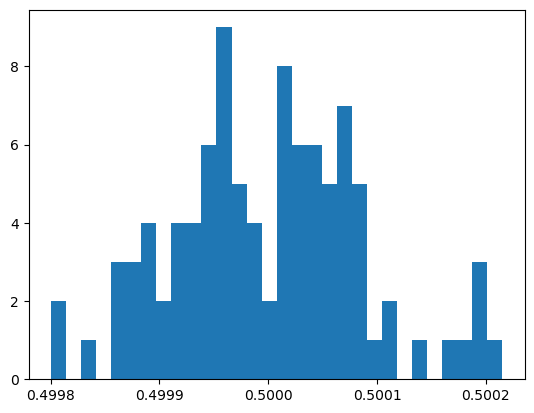

In [170]:
# Plot the histogram of the starting points
plt.hist(starting_points[:, :, :, 1].flatten(), bins=30)
plt.show()

In [171]:
starting_state = State({"mbh": starting_points})
"""
log_prior = sampler.compute_log_prior(starting_state.branches_coords)
log_like  = sampler.compute_log_like(starting_state.branches_coords, logp=log_prior)
print("Log-likelihood:\n", log_like)
print("\nLog-prior:\n", log_prior)
"""

'\nlog_prior = sampler.compute_log_prior(starting_state.branches_coords)\nlog_like  = sampler.compute_log_like(starting_state.branches_coords, logp=log_prior)\nprint("Log-likelihood:\n", log_like)\nprint("\nLog-prior:\n", log_prior)\n'

In [172]:
sampler.run_mcmc(starting_state, nsteps=nsteps, progress=True)

100%|██████████| 5/5 [01:17<00:00, 15.43s/it]


Parameter mT in chain An Example Contour is not constrained
Parameter a1 in chain An Example Contour is not constrained
Parameter dist in chain An Example Contour is not constrained
Parameter phi_ref in chain An Example Contour is not constrained
Parameter f_ref in chain An Example Contour is not constrained
Parameter lam in chain An Example Contour is not constrained
Parameter beta in chain An Example Contour is not constrained
Parameter psi in chain An Example Contour is not constrained
Parameter t_ref in chain An Example Contour is not constrained


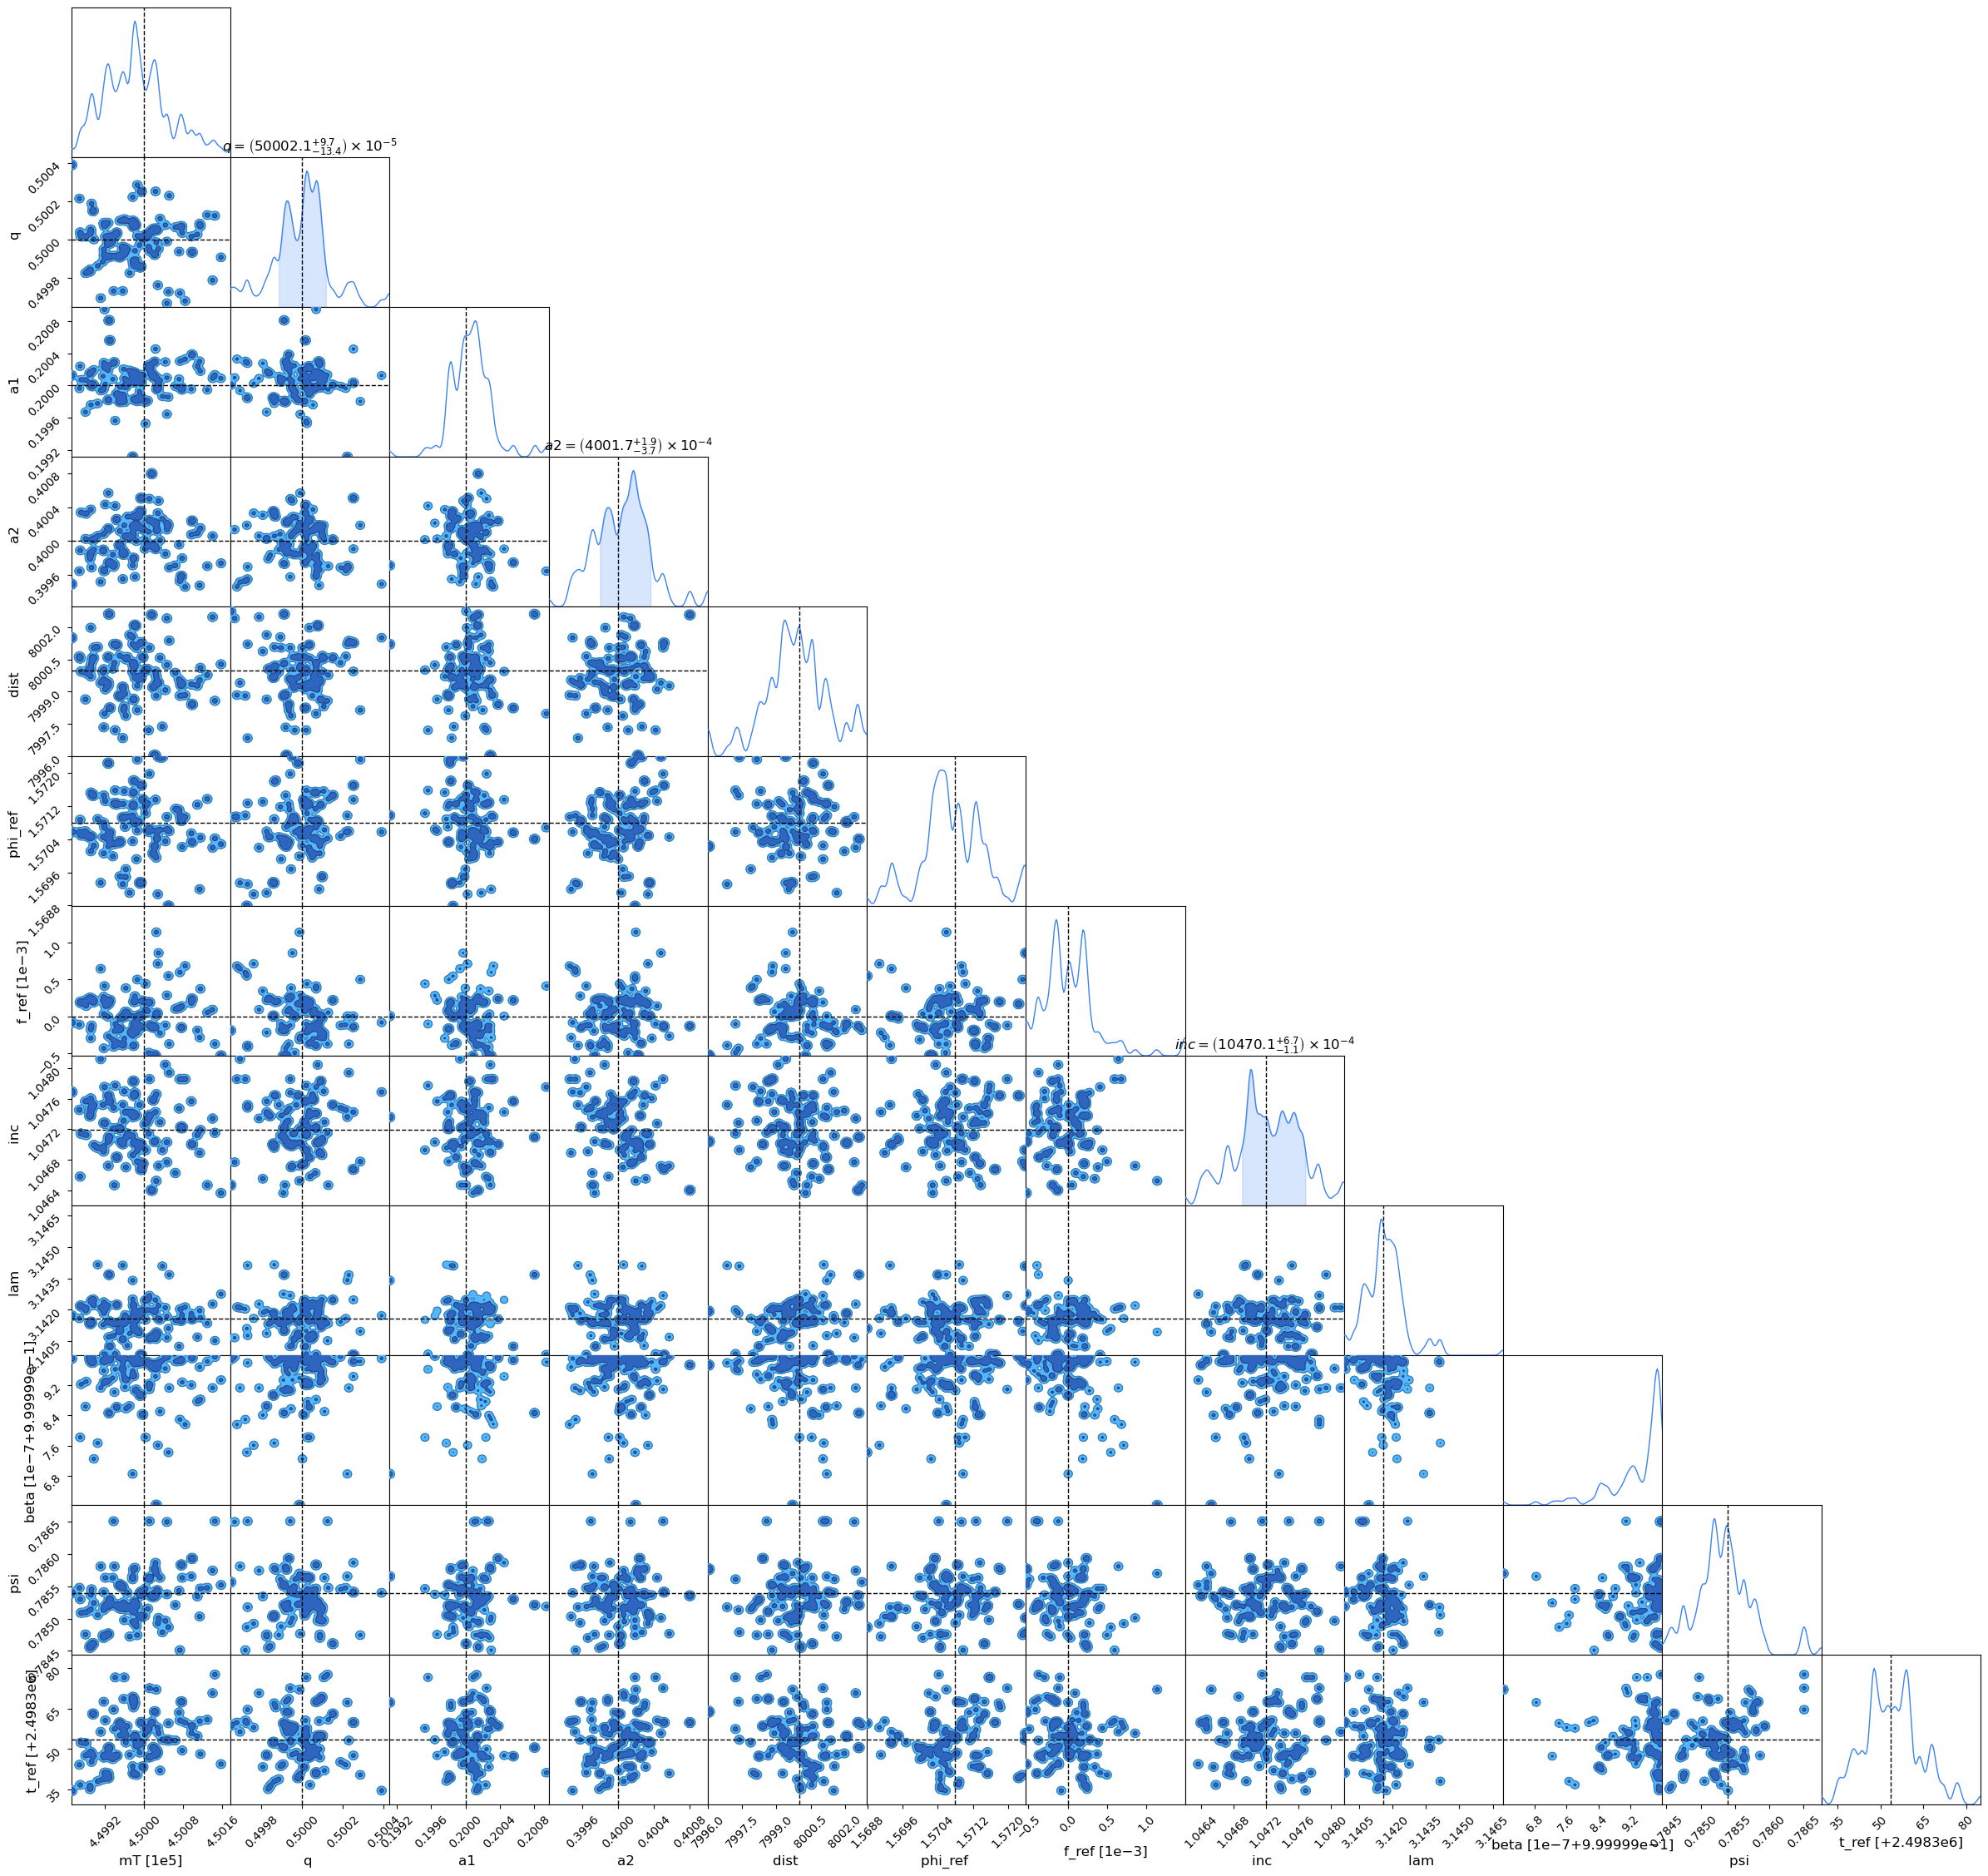

In [173]:
from chainconsumer import Chain, ChainConsumer, make_sample, Truth
import pandas as pd
samples = sampler.get_chain()["mbh"][:, 0].reshape(-1, 12)
df = pd.DataFrame(samples, columns=['mT',
                                    'q',
                                    'a1',
                                    'a2',
                                    'dist',
                                    'phi_ref',
                                    'f_ref',
                                    'inc',
                                    'lam',
                                    'beta',
                                    'psi',
                                    't_ref'])

# df.drop(columns=['f_ref'], inplace=True)  # Remove f_ref column if not needed
# df.to_pickle("mcmc_samples.pkl")

#burn_in_2 = 5000                           # Remove burn-in samples if needed
#df_post_burnin = df.iloc[burn_in_2:]

c = ChainConsumer() 
c.add_chain(Chain(samples=df, name="An Example Contour"))
c.add_truth(Truth(location={"mT"        : injection_parameters[0],
                            "q"         : injection_parameters[1], 
                            "a1"        : injection_parameters[2],
                            "a2"        : injection_parameters[3],
                            "dist"      : injection_parameters[4],
                            "phi_ref"   : injection_parameters[5],
                            "f_ref"     : injection_parameters[6],
                            "inc"       : injection_parameters[7],
                            "lam"       : injection_parameters[8],
                            "beta"      : injection_parameters[9],
                            "psi"       : injection_parameters[10],
                            "t_ref"     : injection_parameters[11]}))
fig = c.plotter.plot()

In [174]:
#sampler.get_chain()["mbh"]

#np.save("chain.npy", sampler.get_chain()["mbh"])

#arr = np.load("chain.npy")

arr = sampler.get_chain()["mbh"]

In [175]:
log_like_samples = sampler.get_log_like()

In [176]:
log_like_samples

array([[[ -38.41314551,  -38.29728182,  -38.67678861,  -40.71265851,
          -38.46502286,  -39.77727199,  -39.25611173,  -38.82923516,
          -41.37124158,  -38.99971729,  -39.39636989,  -39.09916845,
          -39.54117165,  -38.34382452,  -38.43364983,  -38.23363834,
          -41.41516629,  -38.68828282,  -39.67626886,  -38.49934302,
          -39.45240933,  -38.33640011,  -39.41196958,  -40.57768635],
        [ -39.74312665,  -39.72924253,  -39.72693621,  -43.97826277,
          -43.4388229 ,  -40.9465421 ,  -42.7459282 ,  -45.69428106,
          -38.80691189,  -42.23525529,  -39.31236378,  -42.59305601,
          -38.65449701,  -41.16054795,  -40.09386824,  -39.93273142,
          -38.98716163,  -40.96380498,  -40.49104381,  -46.09591334,
          -38.37610104,  -39.98374563,  -41.71361042,  -42.14893344],
        [ -39.80712581,  -38.78831243,  -44.73077564,  -52.33416881,
          -39.95174122,  -41.72225994,  -40.18034239,  -38.41354554,
          -38.85039763,  -40.014

In [177]:
log_like_samples[:,:,0]

array([[-38.41314551, -39.74312665, -39.80712581, -39.96968304],
       [-40.43104335, -39.50686239, -45.90288415, -55.42281383],
       [-38.35457456, -40.29505775, -39.46923491, -54.39600656],
       [-38.35457456, -38.27158865, -48.04867381, -54.39600656],
       [-39.69334112, -38.95263891, -45.9874451 , -67.75346472]])

Parameter mT in chain An Example Contour is not constrained
Parameter a1 in chain An Example Contour is not constrained
Parameter dist in chain An Example Contour is not constrained
Parameter phi_ref in chain An Example Contour is not constrained
Parameter f_ref in chain An Example Contour is not constrained
Parameter lam in chain An Example Contour is not constrained
Parameter beta in chain An Example Contour is not constrained
Parameter psi in chain An Example Contour is not constrained
Parameter t_ref in chain An Example Contour is not constrained


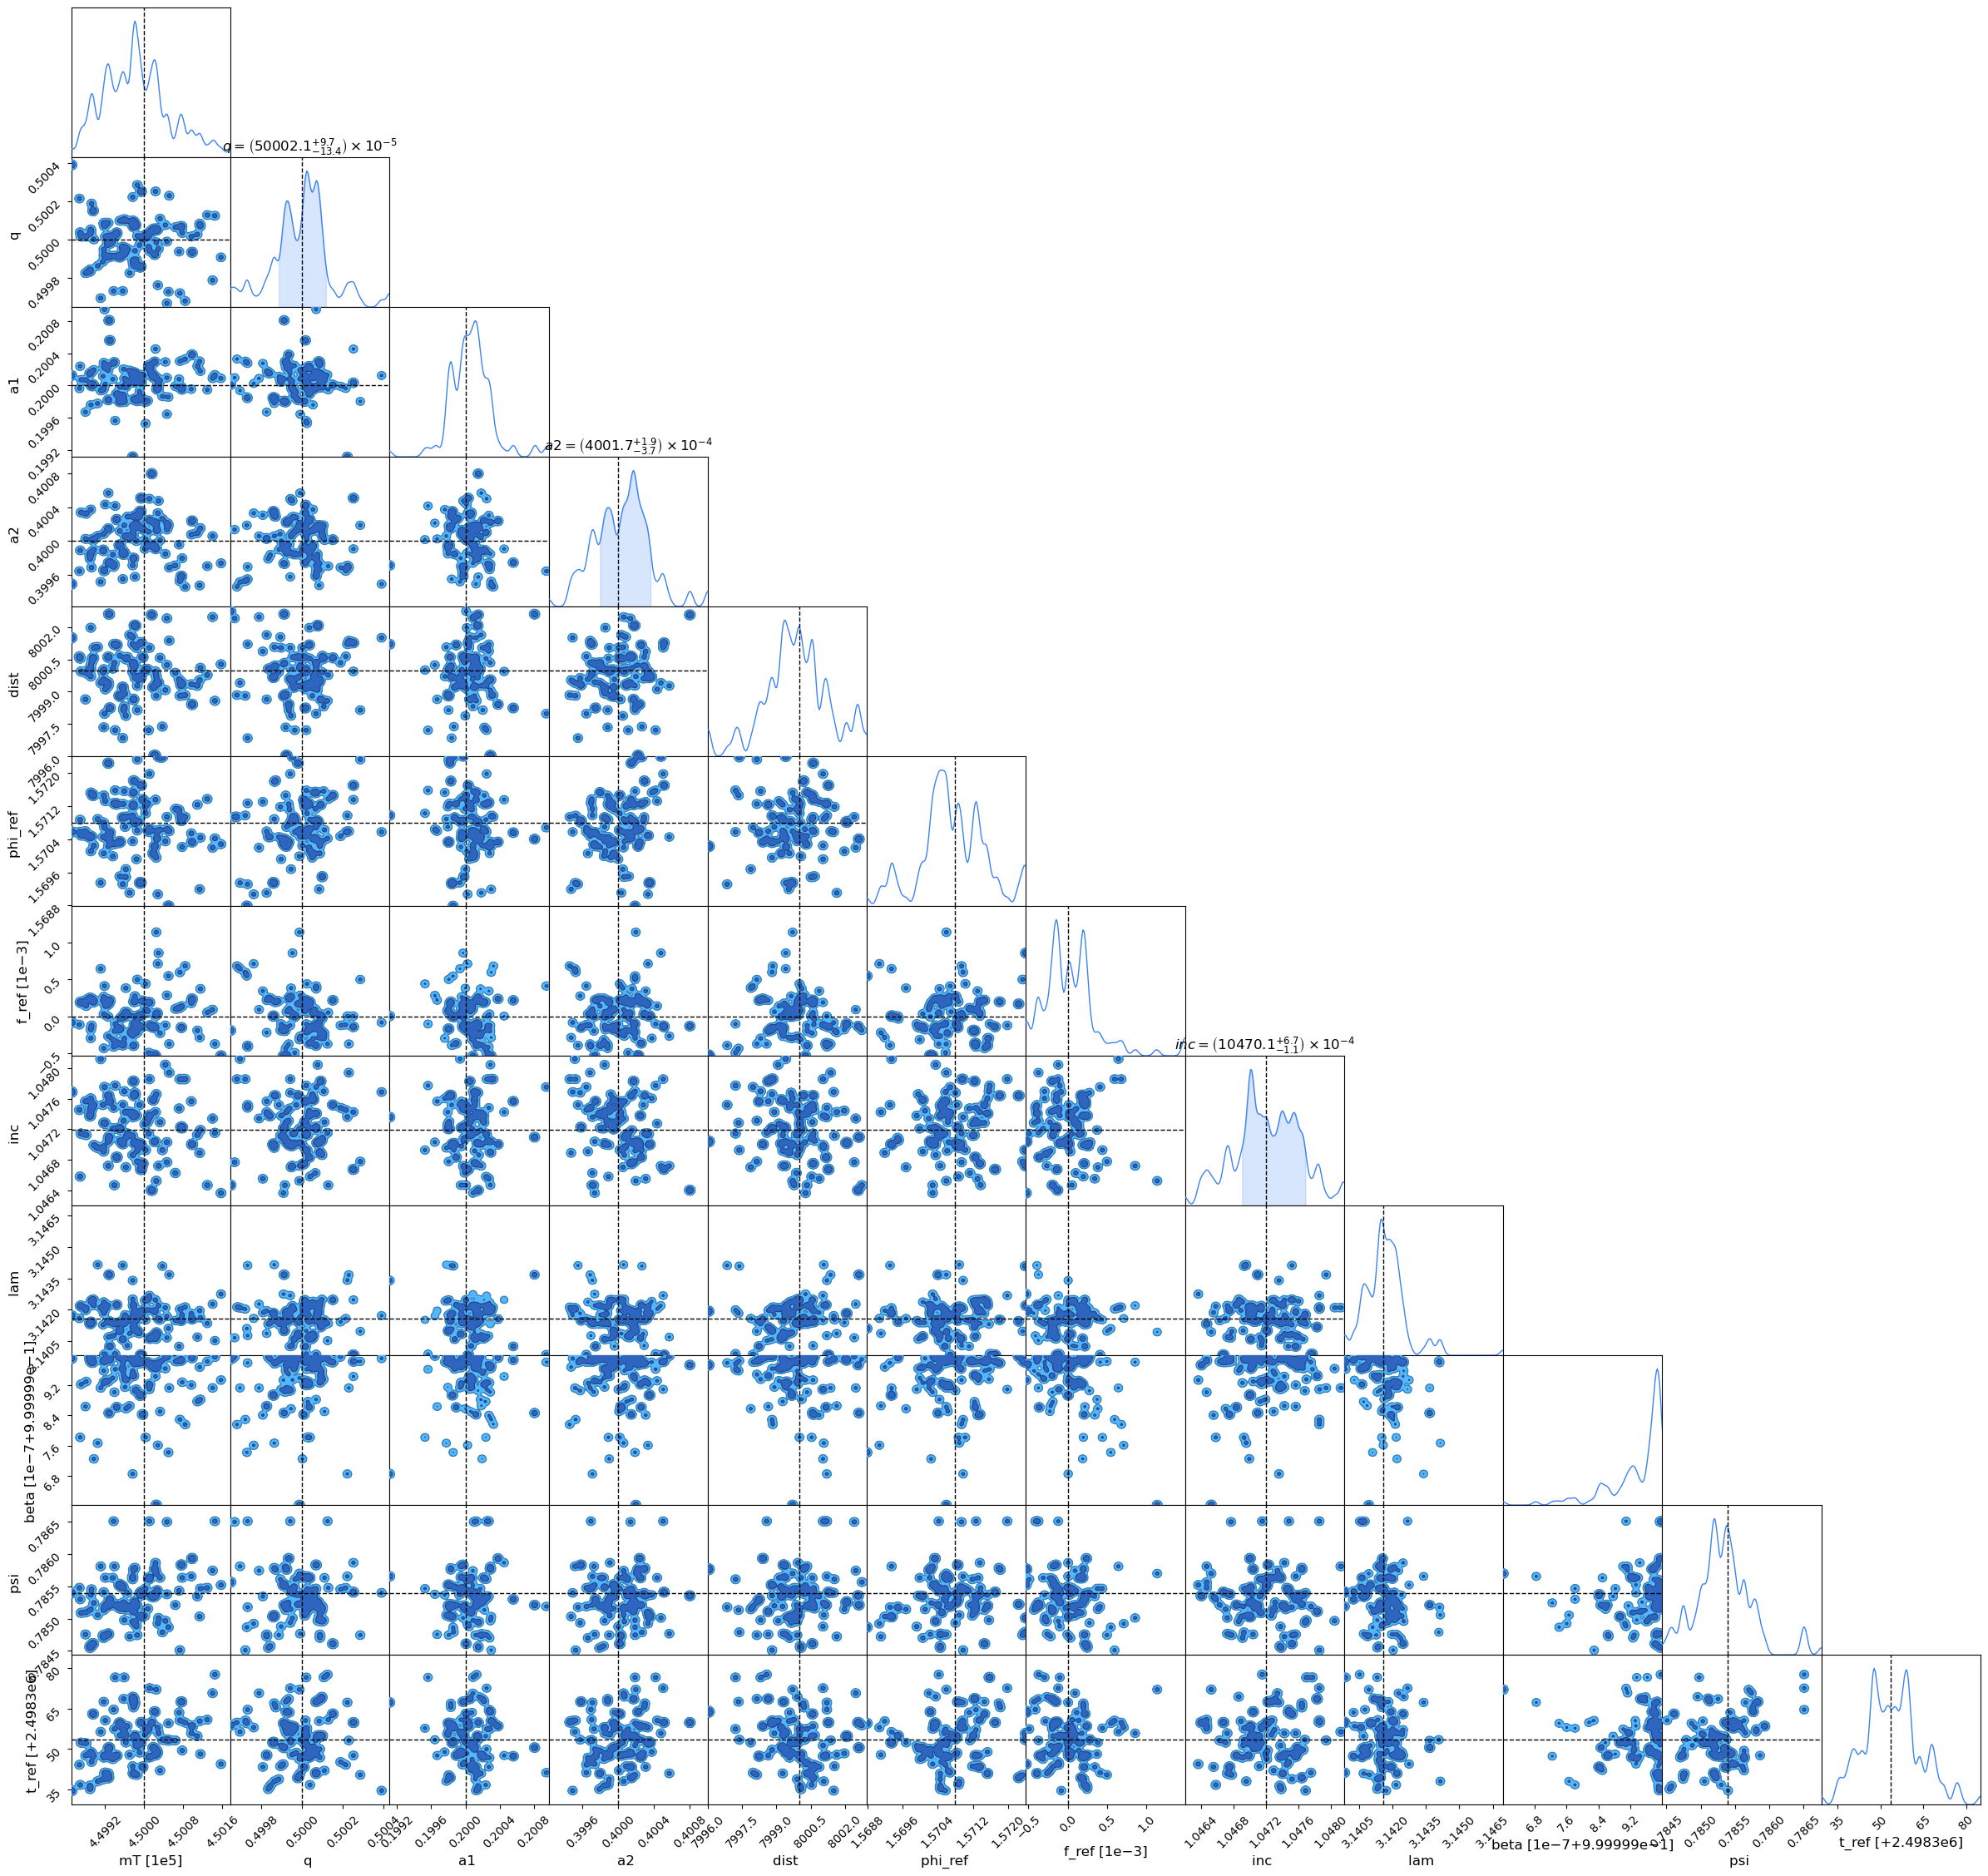

In [178]:
from chainconsumer import Chain, ChainConsumer, make_sample, Truth
import pandas as pd
samples = arr[:, 0].reshape(-1, 12)
df = pd.DataFrame(samples, columns=['mT',
                                    'q',
                                    'a1',
                                    'a2',
                                    'dist',
                                    'phi_ref',
                                    'f_ref',
                                    'inc',
                                    'lam',
                                    'beta',
                                    'psi',
                                    't_ref'])

# df.drop(columns=['f_ref'], inplace=True)  # Remove f_ref column if not needed
# df.to_pickle("mcmc_samples.pkl")

#burn_in_2 = 5000                           # Remove burn-in samples if needed
#df_post_burnin = df.iloc[burn_in_2:]

injection_parameters = np.array([m1+m2, m2/m1, a1, a2, dist / (PC_SI * 1e6), phi_ref, f_ref, inc, lam, beta, psi, t_ref])
c = ChainConsumer() 
c.add_chain(Chain(samples=df, name="An Example Contour"))
c.add_truth(Truth(location={"mT"        : injection_parameters[0],
                            "q"         : injection_parameters[1], 
                            "a1"        : injection_parameters[2],
                            "a2"        : injection_parameters[3],
                            "dist"      : injection_parameters[4],
                            "phi_ref"   : injection_parameters[5],
                            "f_ref"     : injection_parameters[6],
                            "inc"       : injection_parameters[7],
                            "lam"       : injection_parameters[8],
                            "beta"      : injection_parameters[9],
                            "psi"       : injection_parameters[10],
                            "t_ref"     : injection_parameters[11]}))
fig = c.plotter.plot()

In [179]:
starting_points[0, 0, :, 8]

array([3.14140328])

Text(0.5, 0, 'Step')

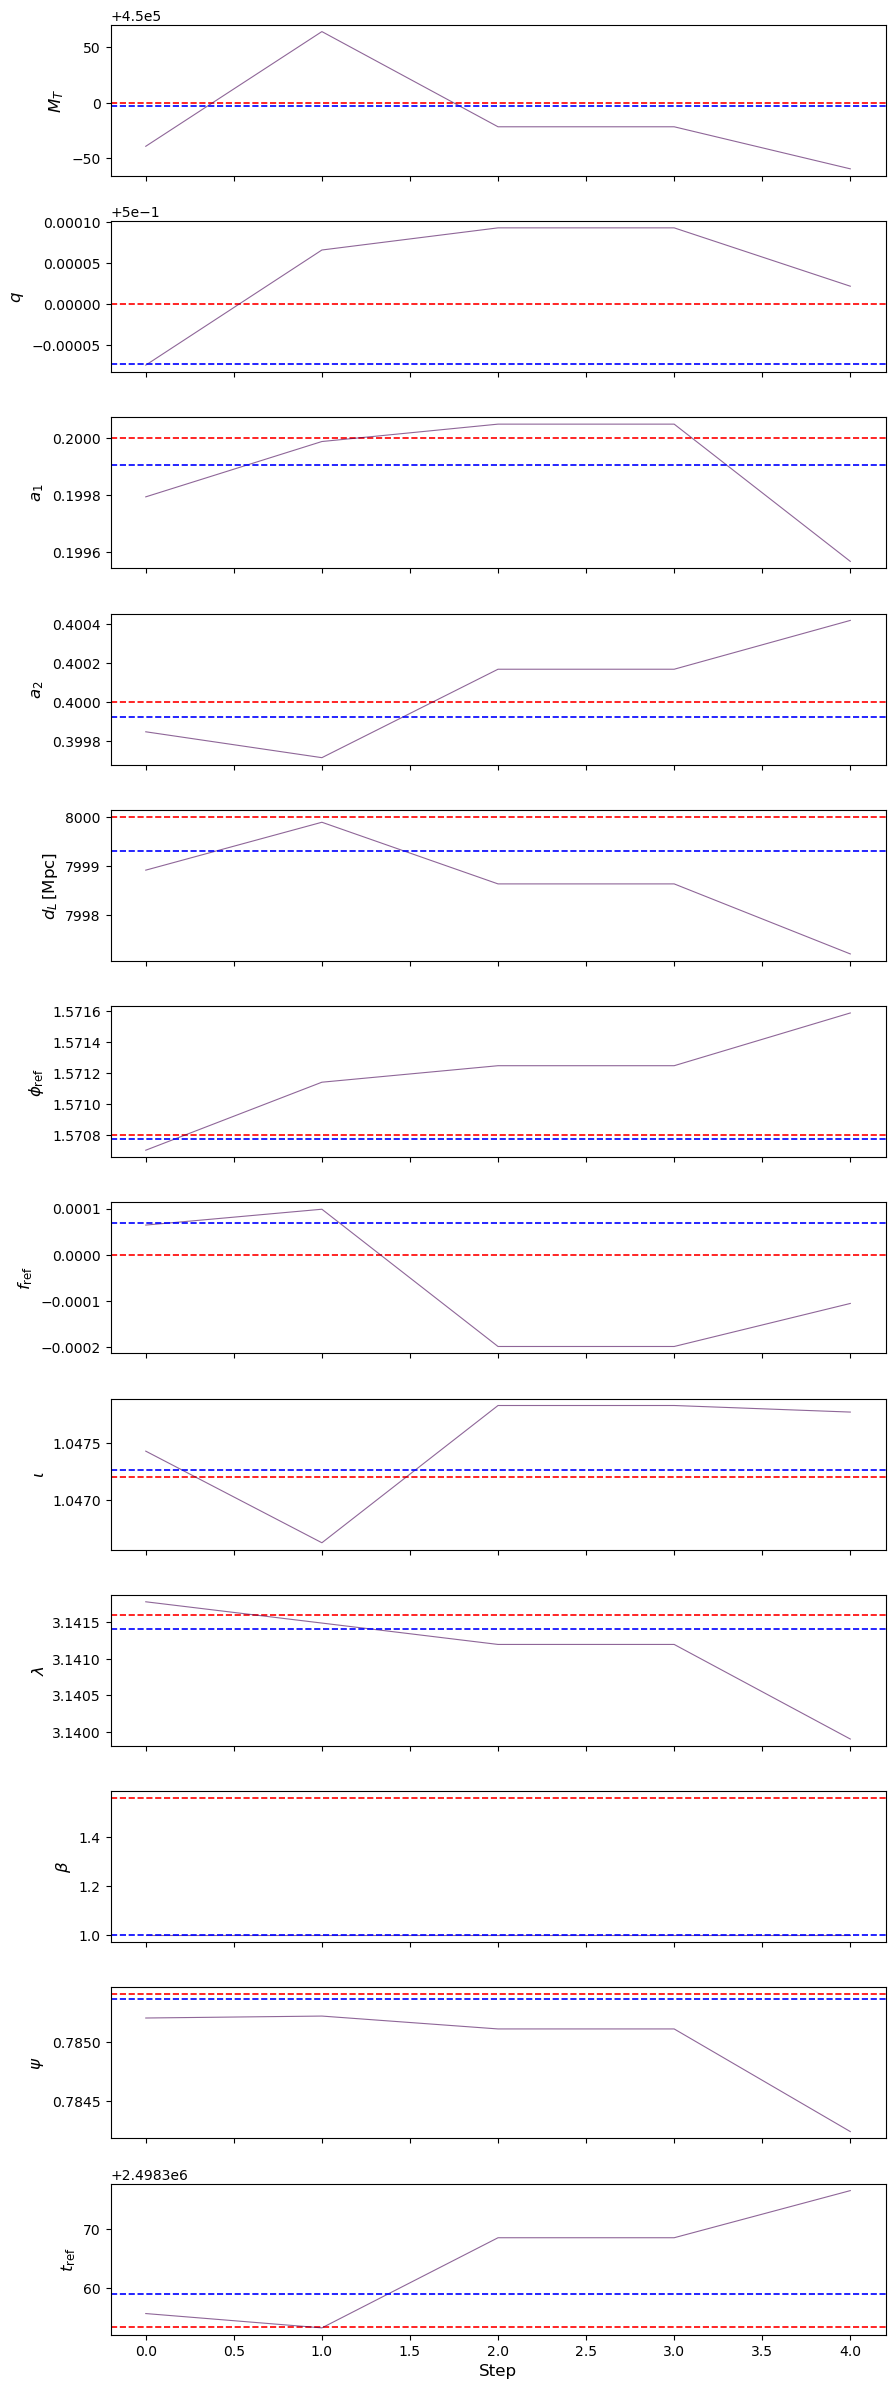

In [180]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

colors = cm.viridis(np.linspace(0, 1, 1))
param_labels = [
    r"$M_T$",
    r"$q$",
    r"$a_1$",
    r"$a_2$",
    r"$d_L \, [\mathrm{Mpc}]$",
    r"$\phi_{\mathrm{ref}}$",
    r"$f_{\mathrm{ref}}$",
    r"$\iota$",
    r"$\lambda$",
    r"$\beta$",
    r"$\psi$",
    r"$t_{\mathrm{ref}}$"
]

fig, ax = plt.subplots(ndims, 1, sharex=True, figsize=(10, 2.5 * ndims))
fig.subplots_adjust(hspace=0.3)


for i in range(ndims):
    ax[i].axhline(injection_parameters[i], color='red', linestyle='--', linewidth=1.2, label="True value")
    for walk in range(1):
        ax[i].plot(arr[:, 0, walk, :, i].flatten(), color=colors[walk], alpha=0.6, linewidth=0.8)
        ax[i].axhline(starting_points[0, walk, :, i], color='blue', linestyle='--', linewidth=1.2, label="True value")
    #ax[i].axhline(injection_parameters[i], color='red', linestyle='--', linewidth=1.2, label="True value")
    ax[i].set_ylabel(param_labels[i], fontsize=12)
    

ax[-1].set_xlabel("Step", fontsize=12)


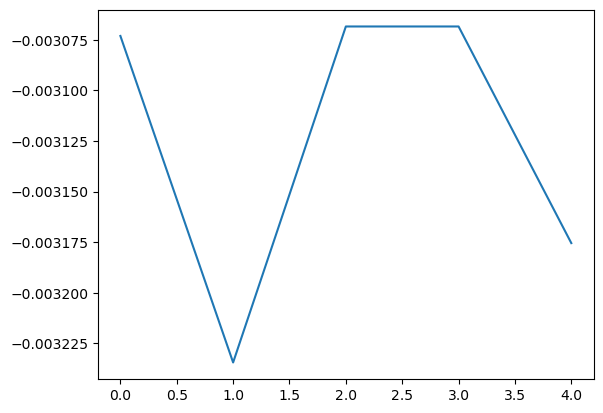

In [181]:
plt.plot(log_like_samples[:,0,0] / analysis.dt)

In [19]:
"""
nwalkers_2 = 50
ntemps_2 = 4
ndims_2 = 12
nleaves_max_2 = 1
nsteps_2 = 500

sampler_2 = EnsembleSampler(
    nwalkers_2,
    ndims_2,
    likelihood,
    priors,
    args=(f_array, analysis),
    branch_names=["mbh"],
    tempering_kwargs=dict(ntemps=ntemps_2),
    nleaves_max=dict(mbh=nleaves_max_2),
    periodic=periodic
)

coords_2 = {"mbh": np.zeros((ntemps_2, nwalkers_2, nleaves_max_2, ndims_2))}
coords_2["mbh"][:, :, 0] = priors["mbh"].rvs(size=(ntemps_2, nwalkers_2))
start_state_rv_from_priors_2 = State({"mbh": coords_2["mbh"]})
sampler_2.run_mcmc(start_state_rv_from_priors_2, nsteps=nsteps_2, progress=True)

samples_2 = sampler_2.get_chain()["mbh"][:, 0].reshape(-1, 12)
df_2 = pd.DataFrame(samples_2, columns=['mT',
                                        'q',
                                        'a1',
                                        'a2',
                                        'dist',
                                        'phi_ref',
                                        'f_ref',
                                        'inc',
                                        'lam',
                                        'beta',
                                        'psi',
                                        't_ref'])
c_2 = ChainConsumer()
c_2.add_chain(Chain(samples=df_2, name="An Example Contour"))
c_2.add_truth(Truth(location={"mT"      : injection_parameters[0],
                            "q"         : injection_parameters[1], 
                            "a1"        : injection_parameters[2],
                            "a2"        : injection_parameters[3],
                            "dist"      : injection_parameters[4],
                            "phi_ref"   : injection_parameters[5],
                            "f_ref"     : injection_parameters[6],
                            "inc"       : injection_parameters[7],
                            "lam"       : injection_parameters[8],
                            "beta"      : injection_parameters[9],
                            "psi"       : injection_parameters[10],
                            "t_ref"     : injection_parameters[11]}))
fig_2 = c_2.plotter.plot()

df_2.to_pickle("mcmc_samples_2.pkl")
"""

'\nnwalkers_2 = 50\nntemps_2 = 4\nndims_2 = 12\nnleaves_max_2 = 1\nnsteps_2 = 500\n\nsampler_2 = EnsembleSampler(\n    nwalkers_2,\n    ndims_2,\n    likelihood,\n    priors,\n    args=(f_array, analysis),\n    branch_names=["mbh"],\n    tempering_kwargs=dict(ntemps=ntemps_2),\n    nleaves_max=dict(mbh=nleaves_max_2),\n    periodic=periodic\n)\n\ncoords_2 = {"mbh": np.zeros((ntemps_2, nwalkers_2, nleaves_max_2, ndims_2))}\ncoords_2["mbh"][:, :, 0] = priors["mbh"].rvs(size=(ntemps_2, nwalkers_2))\nstart_state_rv_from_priors_2 = State({"mbh": coords_2["mbh"]})\nsampler_2.run_mcmc(start_state_rv_from_priors_2, nsteps=nsteps_2, progress=True)\n\nsamples_2 = sampler_2.get_chain()["mbh"][:, 0].reshape(-1, 12)\ndf_2 = pd.DataFrame(samples_2, columns=[\'mT\',\n                                        \'q\',\n                                        \'a1\',\n                                        \'a2\',\n                                        \'dist\',\n                                        

In [20]:
"""
# read from pickle
injection_parameters = np.array([m1+m2, m2/m1, a1, a2, dist / (PC_SI * 1e6), phi_ref, f_ref, inc, lam, beta, psi, t_ref])

df = pd.read_pickle("mcmc_samples.pkl")

burn_in_1 = 2500 
df_post_burnin = df.iloc[burn_in_1:]

c_1 = ChainConsumer()
c_1.add_chain(Chain(samples=df_post_burnin, name="An Example Contour"))
c_1.add_truth(Truth(location={"mT"      : injection_parameters[0],
                            "q"         : injection_parameters[1], 
                            "a1"        : injection_parameters[2],
                            "a2"        : injection_parameters[3],
                            "dist"      : injection_parameters[4],
                            "phi_ref"   : injection_parameters[5],
                            "f_ref"     : injection_parameters[6],
                            "inc"       : injection_parameters[7],
                            "lam"       : injection_parameters[8],
                            "beta"      : injection_parameters[9],
                            "psi"       : injection_parameters[10],
                            "t_ref"     : injection_parameters[11]}))
fig_1 = c_1.plotter.plot()
"""

'\n# read from pickle\ninjection_parameters = np.array([m1+m2, m2/m1, a1, a2, dist / (PC_SI * 1e6), phi_ref, f_ref, inc, lam, beta, psi, t_ref])\n\ndf = pd.read_pickle("mcmc_samples.pkl")\n\nburn_in_1 = 2500 \ndf_post_burnin = df.iloc[burn_in_1:]\n\nc_1 = ChainConsumer()\nc_1.add_chain(Chain(samples=df_post_burnin, name="An Example Contour"))\nc_1.add_truth(Truth(location={"mT"      : injection_parameters[0],\n                            "q"         : injection_parameters[1], \n                            "a1"        : injection_parameters[2],\n                            "a2"        : injection_parameters[3],\n                            "dist"      : injection_parameters[4],\n                            "phi_ref"   : injection_parameters[5],\n                            "f_ref"     : injection_parameters[6],\n                            "inc"       : injection_parameters[7],\n                            "lam"       : injection_parameters[8],\n                            "beta"      :

In [21]:
import os
os.system("say 'Computation is done!'")  # macOS only

0